In [58]:
import contextlib
from csv import DictReader
from functools import cached_property
from typing import Iterable, Callable


class logger:  # noqa
    # Fake logger
    log = staticmethod(print)

In [59]:
import doctest
from abc import ABC, abstractmethod
from collections import defaultdict, Counter


class AbstractSerialMapper(ABC):

    def __init__(self):
        self._data = []

    @abstractmethod
    def add(self, value, *args, **kwargs):
        pass

    def __len__(self):
        return len(self._data)

    def __getitem__(self, key):
        with contextlib.suppress(IndexError):
            return self._data[key]

    def __iter__(self):
        """Iterates through the indices from 0 to len(self._data)"""
        return iter(range(len(self._data)))


class SerialUnidirectionalMapper(AbstractSerialMapper):
    def __init__(self):
        super().__init__()

    def add(self, data, *args, key=None, **kwargs):
        if key is None:
            self._data.append([data])
        else:
            self._data[key].append(data)


class SerialBidirectionalMapper(AbstractSerialMapper):

    def __init__(self):
        super().__init__()
        self._data = []
        self._inverse_data = defaultdict(lambda: None)

    def __getitem__(self, key):
        return self._data[key]

    def add(self, data, *args, **kwargs):
        self._inverse_data[data] = len(self._data)
        self._data.append(data)

    @property
    def inverse(self):
        return self._inverse_data


class InMemory2DIndexer(object):
    """
    An in-memory 2D indexer for efficiently store rows, columns and their related data from a CSV file.

    This class provides an efficient mechanism to map and store large datasets
    using bijective mappings between row/column names and their corresponding IDs.

    Example usage:
        >>> # Testing the creation of an in-memory 2D indexer
        >>> InMemory2DIndexer.create_from_csv(
        ...     file_path="./ml-32m/ratings.csv",
        ...     row_header="userId",
        ...     column_header="movieId",
        ...     limit=10
        ... )  # doctest:+ELLIPSIS
        Limit of entries (.i.e 10) to load has been reached. Exiting without loading the rest...
        <__main__.InMemory2DIndexer object at ...
        >>> # Testing that we can load data effectively
        >>> indexed_data = InMemory2DIndexer.create_from_csv(
        ...     file_path="./ml-32m/ratings.csv",
        ...     row_header="userId",
        ...     column_header="movieId",
        ...     limit=400
        ... )  # doctest:+ELLIPSIS
        Limit of entries (.i.e 400) to load has been reached. Exiting without loading the rest...
        >>> # Testing the content of the indexed_data
        >>> # Expect `rows_count` to be 5 for the 400th lines indexed
        >>> indexed_data.rows_count == 5
        True
        >>> # Expect `columns_count` to be 327 for the 400th lines indexed
        >>> indexed_data.columns_count == 327
        True
        >>> indexed_data._id_to_row_bmap._data
        ['1', '2', '3', '4', '5']
    """

    LIMIT_TO_LOAD_IN_MEMORY = 1_000_000_000_000

    def _construct_data(self, data, columns):
        return (
            self._data_constructor(data, columns)
            if self._data_constructor is not None
            else data
        )

    def _initialize_attributes(
        self,
        *,
        row_name: str,
        column_name: str,
        file_path: str,
        data_columns: Iterable = None,
        data_constructor: Callable = None,
        limit: int = None,
        verbose: bool = False,
    ):
        self._row_name = row_name
        self._column_name = column_name
        self._file_path = file_path
        self._verbose = verbose
        self._data_columns = data_columns
        self._data_constructor = data_constructor
        self._limit = limit or self.LIMIT_TO_LOAD_IN_MEMORY

        self._matrix_value_constructor = float
        self._id_to_column_bmap = SerialBidirectionalMapper()  # bijective mapping
        self._id_to_row_bmap = SerialBidirectionalMapper()
        self._data_by_row_id = SerialUnidirectionalMapper()  # subjective mapping
        self._data_by_column_id = SerialUnidirectionalMapper()

    @classmethod
    def create_from_csv(
        cls,
        *,
        file_path: str,
        row_header: str,
        column_header: str,
        data_columns: Iterable = None,
        data_constructor: Callable = None,
        limit: int = None,
        verbose: bool = False,
    ) -> "InMemory2DIndexer":

        self = cls()
        self._initialize_attributes(
            row_name=row_header,
            column_name=column_header,
            file_path=file_path,
            data_columns=data_columns,
            data_constructor=data_constructor,
            limit=limit,
            verbose=verbose,
        )

        indexed_count = 0

        try:
            with open(file_path, mode="r", newline="") as csvfile:
                for line_count, line in enumerate(DictReader(csvfile)):
                    row, column = line[self._row_name], line[self._column_name]
                    # Unlikely in this dataset but better have this guard
                    if not all([row, column]):
                        logger.log(
                            f"Cannot process the line {line_count}, cause expects `row` and `column` to be defined but got {row} and {column} for them respectively, skipping..."
                        )
                        continue

                    row_id = self._id_to_row_bmap.inverse[row]
                    column_id = self._id_to_column_bmap.inverse[column]

                    if row_id is None:
                        # This row is a new one, so add it
                        self._id_to_row_bmap.add(row)

                    if column_id is None:
                        # This column is a new one, so add it
                        self._id_to_column_bmap.add(column)

                    # Add the data without the useless columns for indexing
                    data = self._construct_data(line, data_columns)

                    self._data_by_row_id.add(data=data, key=row_id)
                    self._data_by_column_id.add(data=data, key=column_id)

                    if verbose:
                        logger.log(
                            f"Indexed the line {indexed_count} of {file_path} successfully"
                        )

                    indexed_count += 1
                    if indexed_count == self._limit:
                        logger.log(
                            f"Limit of entries (.i.e {limit}) to load has been reached. Exiting without loading the rest... "
                        )
                        break

            # Return the created instance
            return self
        except (FileNotFoundError, KeyError) as exc:
            logger.log(
                f"Cannot create `InMemory2DIndexer` instance from the given `file_path` .i.e {file_path}. Attempt failed with exception {exc}"
            )
            raise

    @property
    def rows_count(self) -> int:
        return len(self._id_to_row_bmap)

    @property
    def columns_count(self) -> int:
        return len(self._id_to_column_bmap)

    @cached_property
    def row_id_degree_map(self):
        return {
            row_id: len(self._data_by_row_id[row_id]) for row_id in self._id_to_row_bmap
        }

    @cached_property
    def column_id_degree_map(self):
        return {
            column_id: len(self._data_by_column_id[column_id])
            for column_id in self._id_to_column_bmap
        }

    def plot_data_column_distribution_as_hist(
        self,
        data_column: str,
        plot_title: str = "Distribution of Data Column",
        plot_xlabel: str = "Data Column",
        plot_ylabel: str = "Count",
    ):
        from matplotlib import pyplot as plt

        data_to_plot = []
        for row_id in self._id_to_row_bmap:
            for data in self._data_by_row_id[row_id]:
                data_to_plot.append(data[data_column])

        plt.figure(figsize=(10, 6))
        plt.hist(data_to_plot, bins=10, edgecolor="black")
        plt.title(plot_title)
        plt.xlabel(plot_xlabel)
        plt.ylabel(plot_ylabel)
        plt.show()

    def plot_power_low_distribution(self, axe: str):  # noqa
        import numpy as np
        import matplotlib.pyplot as plt

        axe_to_degree_attr_map = {
            self._row_name: self.row_id_degree_map,
            self._column_name: self.column_id_degree_map,
        }
        degrees_occurrences = axe_to_degree_attr_map[axe]
        degrees_occurrences_counter = Counter(degrees_occurrences.values())

        # Generate some sample data for demonstration
        degrees = np.logspace(0, 5, 100)  # Degree values (x-axis)
        item_frequencies = degrees ** (-0.77)  # Sample power-law distribution for items
        user_frequencies = degrees ** (-1.4) * np.exp(-degrees / 70)  # Sample for users

        # Create the plot
        fig, ax = plt.subplots(1, 2, figsize=(10, 5))  # Two subplots side by side

        # Xbox Movies Plot
        ax[0].loglog(
            degrees_occurrences_counter.keys(),
            degrees_occurrences_counter.values(),
            "g.",
            label="items",
        )  # Green dots for items
        ax[0].loglog(
            degrees, user_frequencies, "b.", label="users"
        )  # Blue dots for users
        ax[0].set_title("Xbox movies")
        ax[0].set_xlabel("degree")
        ax[0].set_ylabel("frequency")
        ax[0].legend()

        # Netflix Plot
        ax[1].loglog(
            degrees, item_frequencies, "g.", label="items"
        )  # Green dots for items
        ax[1].loglog(
            degrees, user_frequencies, "b.", label="users"
        )  # Blue dots for users
        ax[1].set_title("Netflix (4 and 5 stars)")
        ax[1].set_xlabel("degree")
        ax[1].set_ylabel("frequency")
        ax[1].legend()

        # Show plot
        plt.tight_layout()
        plt.show()


# TODO: Implement this methods, if the need shows up
# indexed_data.find_row_by_row_id()
# indexed_data.find_column_by_colum_id()
# indexed_data.find_column_by_id()

# Test that the indexer works well before proceeding
doctest.testmod(report=True, verbose=True)

Trying:
    InMemory2DIndexer.create_from_csv(
        file_path="./ml-32m/ratings.csv",
        row_header="userId",
        column_header="movieId",
        limit=10
    )  # doctest:+ELLIPSIS
Expecting:
    Limit of entries (.i.e 10) to load has been reached. Exiting without loading the rest...
    <__main__.InMemory2DIndexer object at ...
ok
Trying:
    indexed_data = InMemory2DIndexer.create_from_csv(
        file_path="./ml-32m/ratings.csv",
        row_header="userId",
        column_header="movieId",
        limit=400
    )  # doctest:+ELLIPSIS
Expecting:
    Limit of entries (.i.e 400) to load has been reached. Exiting without loading the rest...
ok
Trying:
    indexed_data.rows_count == 5
Expecting:
    True
ok
Trying:
    indexed_data.columns_count == 327
Expecting:
    True
ok
Trying:
    indexed_data._id_to_row_bmap._data
Expecting:
    ['1', '2', '3', '4', '5']
ok
23 items had no tests:
    __main__
    __main__.AbstractSerialMapper
    __main__.AbstractSerialMapper.__get

TestResults(failed=0, attempted=5)

In [60]:
# From here, we will use the domain vocabulary
indexed_data = InMemory2DIndexer.create_from_csv(
    file_path="./ml-32m/ratings.csv",
    row_header="userId",
    column_header="movieId",
    data_columns=("rating",),
    limit=400,
)

Limit of entries (.i.e 400) to load has been reached. Exiting without loading the rest... 


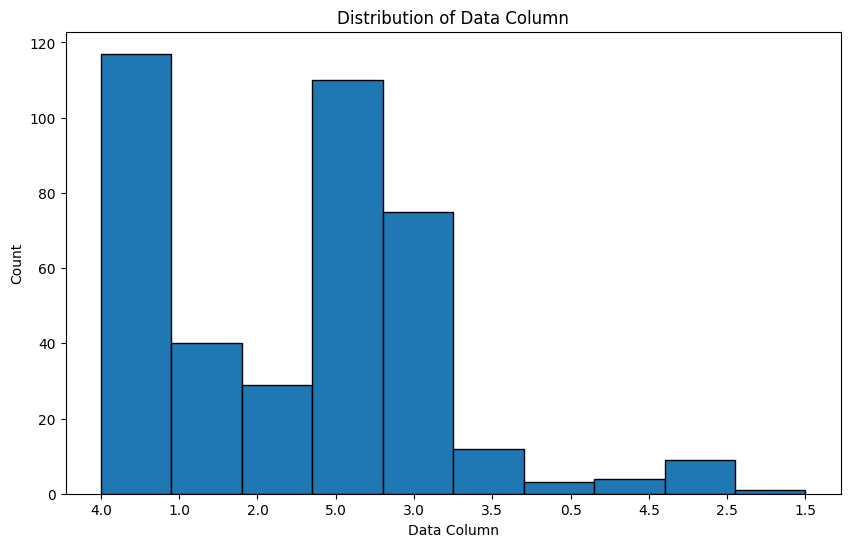

In [61]:
indexed_data.plot_data_column_distribution_as_hist(data_column="rating")

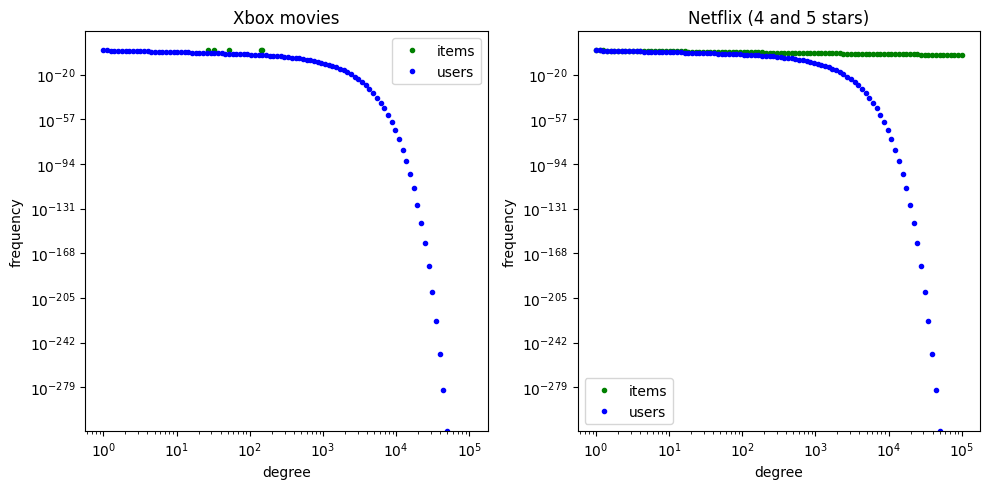

In [62]:
indexed_data.plot_power_low_distribution("userId")